# Using ARIS maps as input.

One of the fundamental building blocks of `TiEMPO2` is the atmospheric screen generated by ARIS. Using this screen, we calculate the PWV values, as function of time and position on the sky. In this notebook, we play around a bit with a map included with `TiEMPO2`. 

In [1]:
import os
import numpy as np
from tiempo2.Atmosphere import Atmosphere

import matplotlib.pyplot as pt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

%load_ext Cython
%load_ext wurlitzer

%matplotlib notebook

prefix_filename = "test" 
path_data = os.path.join("..", "..", "tests", "resources")
pwv0 = 1. 
pwvgrid = 0.2 
max_windspeed = 10 
obs_duration = 420
max_num_strips = 1
x_length_strip = 69
h_column = 1000.
dish_radius = 5

load_spline = False


atm = Atmosphere(prefix_filename, path_data, pwv0, 
                 pwvgrid, max_windspeed, obs_duration, dish_radius,
                 max_num_strips, x_length_strip, load_spline=load_spline)

nx = atm.nx
ny = atm.ny

L_tot_screen = ny * pwvgrid

X, Y = np.mgrid[0:ny:ny * 1j, 0:ny:ny* 1j]

X *= pwvgrid
Y *= pwvgrid

#Convert X and Y to angles on-sky
X = np.degrees(np.arctan((X - L_tot_screen / 2) / h_column))
Y = np.degrees(np.arctan((Y - L_tot_screen / 2) / h_column))
d_cell_ang = np.degrees(pwvgrid / h_column)

windspeed_ang = np.degrees(max_windspeed / h_column) # deg / sec

print(d_cell_ang / windspeed_ang)

Load fits files..
1
Number of atmosphere strips loaded:  1
dimensions atmosphere strips:
0 x:  65536
0 y:  128
0.02


[[0.9826011  0.98261974 0.98244465]
 [0.98268606 0.98271193 0.98257942]
 [0.9827689  0.98275885 0.98272498]]
4
4
[0.         0.         0.         0.         0.4000061  0.60000916
 0.80001221 1.00001526 1.20001831 1.40002136 1.60002441 1.80002747
 2.00003052 2.20003357 2.40003662]
[0.         0.         0.         0.         0.40314961 0.60472441
 0.80629921 1.00787402 1.20944882 1.41102362 1.61259843 1.81417323
 2.01574803 2.21732283 2.41889764]
[0.98253635 0.98253663 0.9825356  0.98253765 0.98254038 0.98254541
 0.9825472  0.98254311 0.98253157 0.98251151 0.98248309 0.98244976
 0.98241323 0.98237619 0.98234225]


<IPython.core.display.Javascript object>


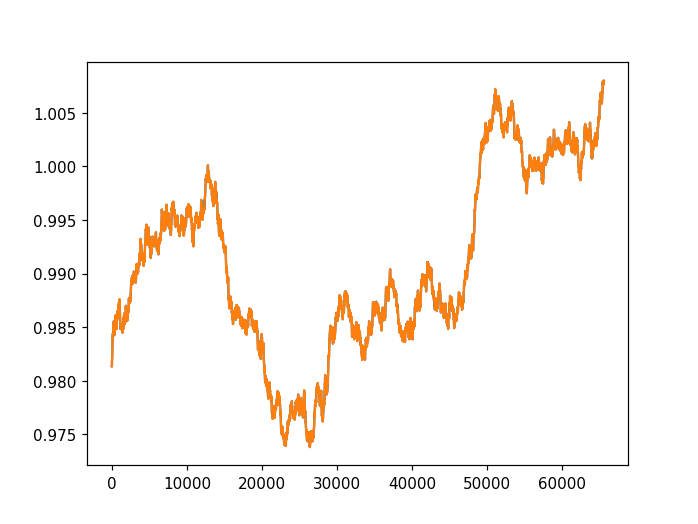

In [7]:
X1, Y1 = np.mgrid[1.1:3.3:3 * 1j, 1.1:3.3:3* 1j]

#X1 *= pwvgrid
#Y1 *= pwvgrid

test_out = atm.func(X1, Y1, grid=False)
print(test_out)

#print((atm.atm_knots[0] == 0).size)
print(atm.atm_knots[0][atm.atm_knots[0] == 0].size)
print(atm.atm_knots[1][atm.atm_knots[1] == 0].size)

print(atm.atm_knots[0][0:15])
print(atm.atm_knots[1][0:15])

print(atm.atm_coeffs[0:15])
sl = slice(50, atm.nx*atm.ny, atm.ny)

pt.plot(atm.atm_coeffs[sl])

pt.plot(atm.PWV_Gauss[:,50])
pt.show()

In [ ]:
fig, ax = pt.subplots(1,2, figsize=(10, 5), gridspec_kw={"wspace" : 0.7})
#atm.PWV[0:ny]
pwv_raw = ax[0].pcolormesh(X, Y, atm.PWV[0:ny])
ax[0].set_aspect(1)
ax[0].set_xlabel("dAz / deg")
ax[0].set_ylabel("dEl / deg")

pwv_gauss = ax[1].pcolormesh(X, Y, atm.PWV_Gauss[0:ny])
ax[1].set_aspect(1)
ax[1].set_xlabel("dAz / deg")
ax[1].set_ylabel("dEl / deg")

divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)

_tc = fig.colorbar(pwv_raw, cax=cax0, orientation="vertical")
_kc = fig.colorbar(pwv_gauss, cax=cax1, orientation="vertical")
_tc.set_label("PWV / mm", rotation=270, labelpad=20)
_kc.set_label("PWV / mm", rotation=270, labelpad=20)

#ax[0].scatter

pt.show()



Now, we apply the windspeed to our atmospheric screen. We record the results for a period of 20 seconds of observation. Here, we re-implement the windspeed framestepping in order to generate the animation. During regular usage, `TiEMPO2` does the stepping internally and implementing an own stepper is not necessary.

In [ ]:
t_end = 200

N_cells_sec = pwvgrid / windspeed_ang # Nr. cells / sec
N_time = round(t_end / N_cells_sec)

t_range = np.linspace(0, t_end, num = N_time)

max_pt = np.max(atm.PWV_Gauss[:N_time,:])
min_pt = np.min(atm.PWV_Gauss[:N_time,:])

fig, ax = pt.subplots(1,1, figsize=(5, 5))
ims = []
for i in range(len(t_range)):
    ind_lo = i
    ind_hi = ny + i

    pwv_gauss = ax.pcolormesh(X, Y, atm.PWV_Gauss[ind_lo:ind_hi], vmin=min_pt, vmax=max_pt)
    ax.set_aspect(1)
    ax.set_xlabel("dAz / deg")
    ax.set_ylabel("dEl / deg")
    
    ims.append([pwv_gauss])
    

ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=0, blit=True)


In [ ]:
pt.clf()
pt.cla()